<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP3_BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: BitPredict

**Forecasting: Principles and Practice** (3rd ed): https://otexts.com/fpp3/

by Rob J Hyndman and George Athanasopoulos

Monash University, Australia

# Importações

In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import absl.logging, os

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Conv1D, Dense, Input, Lambda, Layer, LSTM, Subtract
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import minmax_scale

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

absl.logging.set_verbosity(absl.logging.ERROR)  # Apresentar apenas erros.

## Constantes

In [3]:
SEMENTE = 2008193

COLUNAS = ['Data', 'Abertura', 'Máximo', 'Mínimo', 'Fechamento']

COR_TREINO   = '#663399'
COR_PREVISAO = '#f22424'
COR_TESTE    = '#345cd3'

LINHA_ESPESSURA = 1

TAMANHO_CNN = 128

ATIVACAO_CNN = 'relu'
ATIVACAO_HORIZONTE = 'linear'

PERDA = 'mae'
METRICAS = ['mae', 'mse']

ITERACOES = 100
TAMANHO_LOTE = 128
CAMINHO_MARCOS = 'marcos'

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py

--2023-02-12 19:21:10--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes_temporais.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4157 (4.1K) [text/plain]
Saving to: ‘funcoes_temporais.py’

funcoes_temporais.p 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-02-12 19:21:10 (36.5 MB/s) - ‘funcoes_temporais.py’ saved [4157/4157]



In [5]:
from funcoes_temporais import grafico_series, metricas_modelo, criar_janelas, separar_janelas_treino_teste, criar_marco_modelo

# Dados

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/BTC_USD_20140917_20230131.csv',
                 header=0,
                 names=COLUNAS,
                 usecols=COLUNAS,
                 parse_dates=['Data'],
                 index_col=['Data'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3059 entries, 2014-09-17 to 2023-01-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Abertura    3059 non-null   float64
 1   Máximo      3059 non-null   float64
 2   Mínimo      3059 non-null   float64
 3   Fechamento  3059 non-null   float64
dtypes: float64(4)
memory usage: 119.5 KB


In [8]:
df

,Abertura,Máximo,Mínimo,Fechamento
Data,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2023-01-27,23030.716797,23417.720703,22654.593750,23078.728516
2023-01-28,23079.964844,23165.896484,22908.845703,23031.089844
2023-01-29,23031.449219,23919.890625,22985.070313,23774.566406


In [9]:
df.describe()

,Abertura,Máximo,Mínimo,Fechamento
count,3059.000000,3059.000000,3059.000000,3059.000000
mean,12931.188036,13256.306288,12570.103885,12937.054107
std,16126.299406,16538.601114,15650.315751,16122.253398
min,176.897003,211.731003,171.509995,178.102997
25%,688.562011,704.736023,674.479981,689.175506
50%,7194.892090,7356.223633,7029.289063,7202.844238
75%,17092.044922,17464.872071,16789.533203,17097.668945
max,67549.734375,68789.625000,66382.062500,67566.828125


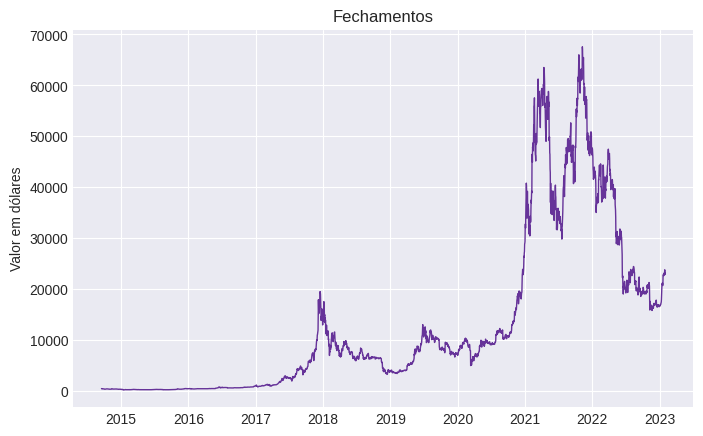

In [10]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

In [11]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2447

In [12]:
X_train = df[:treino_tamanho].index
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2447, 2447, 612, 612)

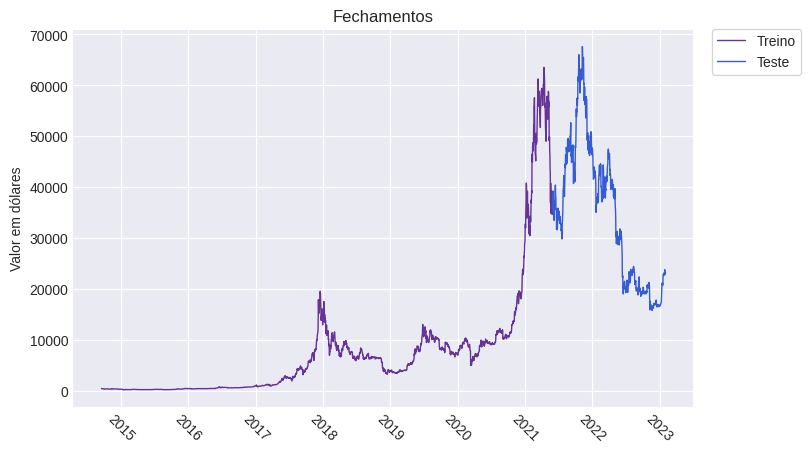

In [13]:
grafico_series(X_treino=X_train, y_treino=y_train,
               X_teste=X_test, y_teste=y_test)

## Dados multivariados (Modelo 6)

What Is Bitcoin Halving? https://www.forbes.com/uk/advisor/investing/cryptocurrency/bitcoin-halving/

In [14]:
df['Premio'] = np.select([df.index < '2016-07-09',
                          df.index < '2020-05-18',
                          True],
                         [25, 12.5, 6.25])

In [15]:
df_escala = pd.DataFrame(data=list(zip(df['Fechamento'], minmax_scale(df['Premio'], feature_range=((df['Fechamento'].max() * 6.25 / 25), df['Fechamento'].max())))),
                         columns=['Fechamento', 'Premio'],
                         index=df.index)

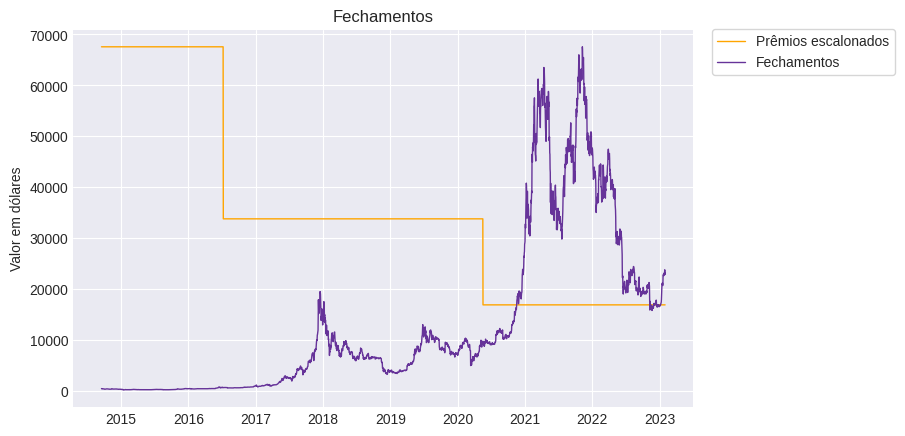

In [16]:
sns.lineplot(data=df_escala, x='Data', y='Premio', color='orange', linewidth=LINHA_ESPESSURA, label='Prêmios escalonados')
sns.lineplot(data=df_escala, x='Data', y='Fechamento', color=COR_TREINO, linewidth=LINHA_ESPESSURA, label='Fechamentos')

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white');

# Modelos

0. Ingênuo
1. Denso (7 janelas, 1 horizonte.)
2. Denso (30 janelas, 1 horizonte.)
3. Denso (30 janelas, 7 horizontes.)
4. Convulacional
5. LSTM
6. Denso (dados multivariados)
7. N-BEATS
8. Conjunto
9. Prevendo o futuro

---
Janelas: quantidade de dados utilizados.

Horizontes: quantidade de previsões.

In [17]:
metricas = [None] * 10

## Modelo 0: Ingênuo

Naïve method: https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method

Para previsões ingênuas, simplesmente definimos todas as previsões como o valor da observação anterior.

In [18]:
y_pred = y_test[:-1]

In [19]:
y_test[:10], y_test[-10:], y_pred[:10], y_pred[-10:]

(array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22720.416016, 22934.431641, 22636.46875 , 23117.859375,
        23032.777344, 23078.728516, 23031.089844, 23774.566406,
        22840.138672, 23139.283203]),
 array([35678.128906, 37332.855469, 36684.925781, 37575.179688,
        39208.765625, 36894.40625 , 35551.957031, 35862.378906,
        33560.707031, 33472.632813]),
 array([22777.625   , 22720.416016, 22934.431641, 22636.46875 ,
        23117.859375, 23032.777344, 23078.728516, 23031.089844,
        23774.566406, 22840.138672]))

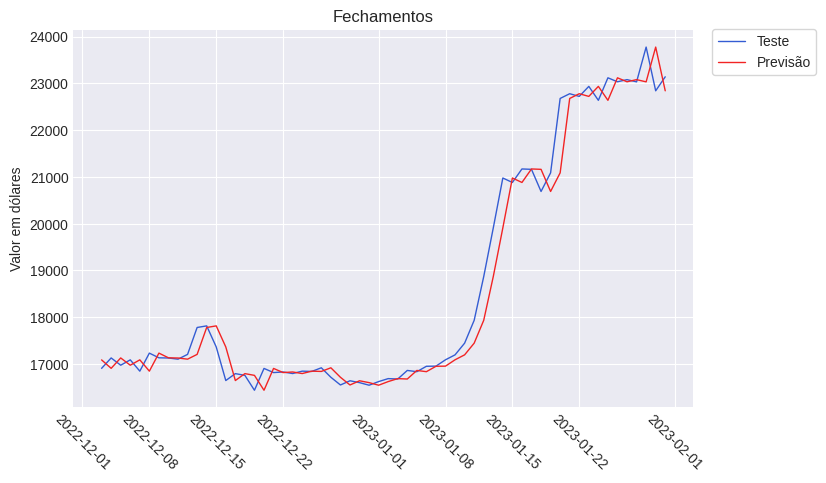

In [20]:
grafico_series(X_teste=X_test, y_teste=y_test,
               X_previsao=X_test[1:], y_previsao=y_pred,
               inicio=-60)

In [21]:
metricas[0] = metricas_modelo(y_test[1:], y_pred)

## Modelo 1: Denso (7 janelas, 1 horizonte.)

In [22]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [23]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_1_denso_7j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 25.3 s, sys: 2.34 s, total: 27.7 s
Wall time: 46.4 s


In [24]:
modelo.summary()

Model: "modelo_1_denso_7j_1h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               1024      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [25]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 2ms/step - loss: 980.0327 - mae: 980.0327 - mse: 1970999.5000


[980.0326538085938, 980.0326538085938, 1970999.5]

In [26]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 2ms/step - loss: 896.0247 - mae: 896.0247 - mse: 1730447.7500


[896.024658203125, 896.024658203125, 1730447.75]

In [27]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


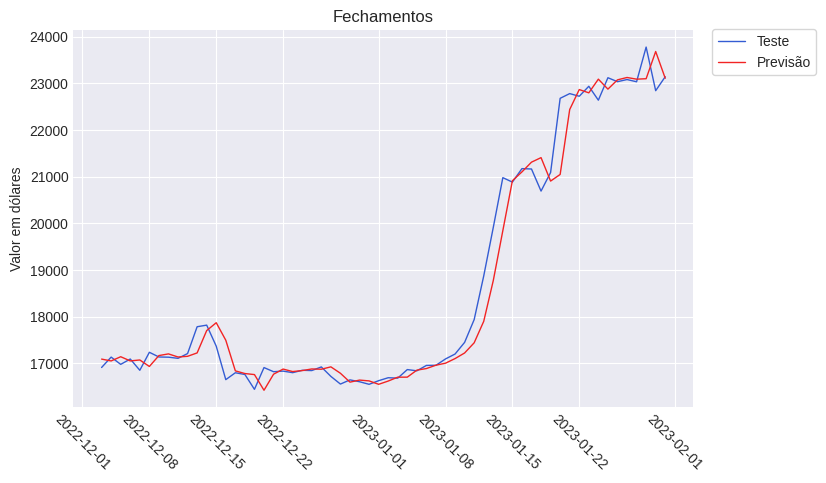

In [28]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [29]:
metricas[1] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 2: Denso (30 janelas, 1 horizonte.)

In [30]:
janela_tamanho = 30
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [31]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_2_denso_30j_1h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 19.7 s, sys: 824 ms, total: 20.5 s
Wall time: 19.2 s


In [32]:
modelo.summary()

Model: "modelo_2_denso_30j_1h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               3968      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [33]:
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 4ms/step - loss: 1090.9266 - mae: 1090.9266 - mse: 2357290.0000


[1090.9266357421875, 1090.9266357421875, 2357290.0]

In [34]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 4ms/step - loss: 966.4670 - mae: 966.4670 - mse: 1918436.5000


[966.4669799804688, 966.4669799804688, 1918436.5]

In [35]:
previsoes = modelo.predict(janelas_teste)

19/19 [==============================] - 0s 2ms/step


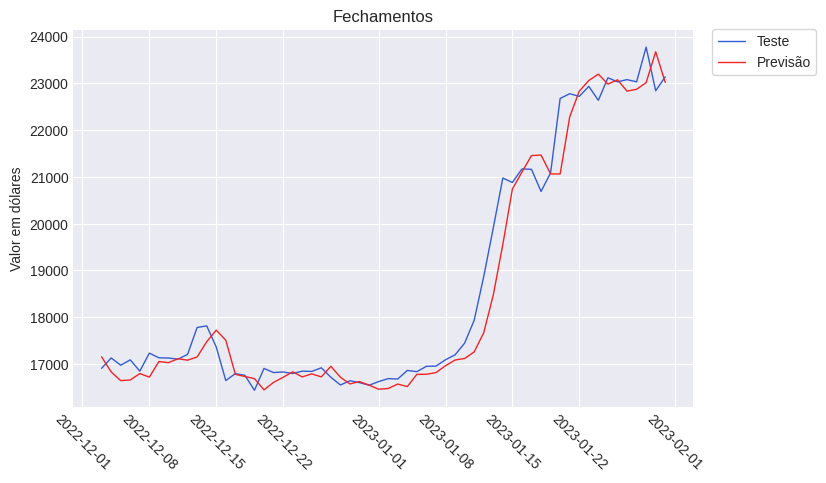

In [36]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [37]:
metricas[2] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 3: Denso (30 janelas, 7 horizontes.)

In [38]:
janela_tamanho = 30
horizonte_tamanho = 7

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [39]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_3_denso_30j_7h'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 18.7 s, sys: 802 ms, total: 19.5 s
Wall time: 18.3 s


In [40]:
modelo.summary()

Model: "modelo_3_denso_30j_7h"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               3968      
                                                                 
 camada_saida (Dense)        (None, 7)                 903       
                                                                 
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


In [41]:
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 2ms/step - loss: 1842.2017 - mae: 1842.2017 - mse: 6966784.0000


[1842.20166015625, 1842.20166015625, 6966784.0]

In [42]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

19/19 [==============================] - 0s 2ms/step - loss: 1809.7413 - mae: 1809.7413 - mse: 6800584.5000


[1809.7413330078125, 1809.7413330078125, 6800584.5]

In [43]:
previsoes = modelo.predict(janelas_teste)

19/19 [==============================] - 0s 2ms/step


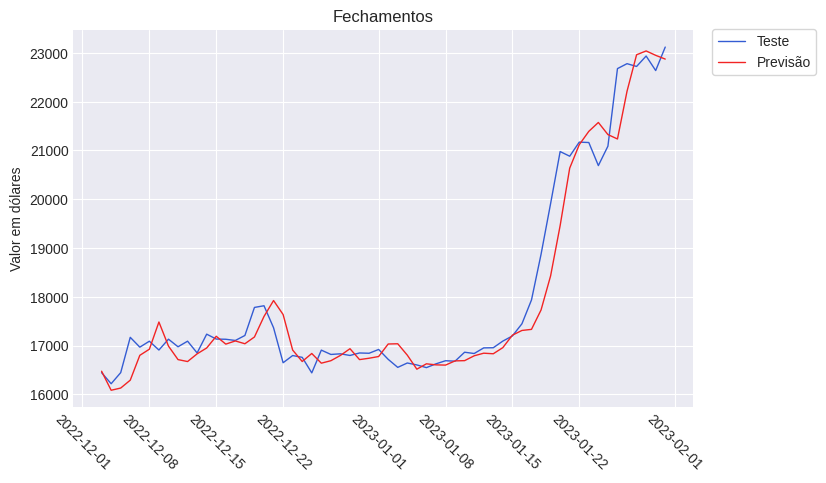

In [44]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=horizontes_teste[:, 0],
               X_previsao=X_test[-len(janelas_teste):], y_previsao=previsoes[:, 0],
               inicio=-60)

In [45]:
metricas[3] = metricas_modelo(horizontes_teste[:, 0], previsoes[:, 0])

## Modelo 4: Convulacional

In [46]:
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [47]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_4_convulacional'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))  # Adiciona uma dimensão aos dados.

modelo.add(Conv1D(filters=128,
                  kernel_size=janela_tamanho,
                  padding='causal',
                  activation=ATIVACAO_CNN,
                  name='camada_convulacional'))

modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 37.7 s, sys: 1.67 s, total: 39.4 s
Wall time: 41.1 s


In [48]:
modelo.summary()

Model: "modelo_4_convulacional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 7)              0         
                                                                 
 camada_convulacional (Conv1  (None, 1, 128)           6400      
 D)                                                              
                                                                 
 camada_saida (Dense)        (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [49]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 5ms/step - loss: 912.7504 - mae: 912.7504 - mse: 1793190.5000


[912.7504272460938, 912.7504272460938, 1793190.5]

In [50]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 911.9864 - mae: 911.9864 - mse: 1787270.7500


[911.9863891601562, 911.9863891601562, 1787270.75]

In [51]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


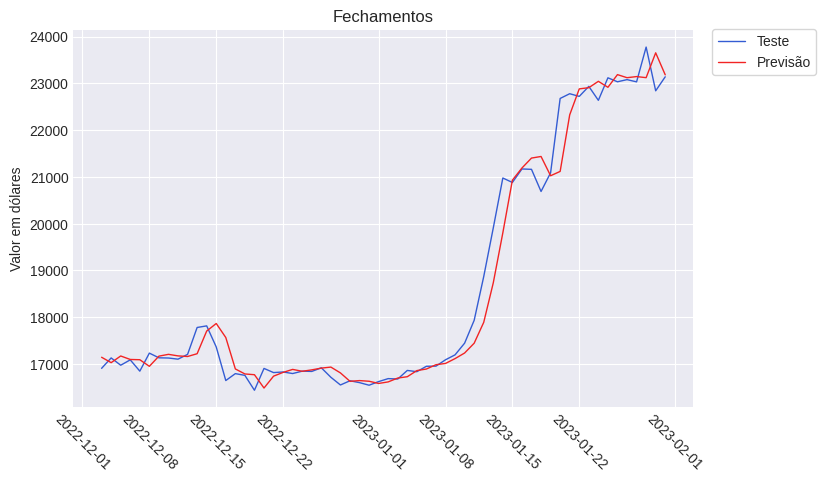

In [52]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [53]:
metricas[4] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 5: Memória de longa e curta durações (LSTM)

In [54]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_5_lstm'

modelo = Sequential(name=modelo_nome)

modelo.add(Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda'))
modelo.add(LSTM(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_lstm'))  # Ativação 'relu' no lugar de 'tanh' por motivo de performance.
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 1min 14s, sys: 2.19 s, total: 1min 16s
Wall time: 1min 23s


In [55]:
modelo.summary()

Model: "modelo_5_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_lambda (Lambda)      (None, 1, 7)              0         
                                                                 
 camada_lstm (LSTM)          (None, 128)               69632     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [56]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 1133.9752 - mae: 1133.9752 - mse: 2455132.5000


[1133.9752197265625, 1133.9752197265625, 2455132.5]

In [57]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 932.2263 - mae: 932.2263 - mse: 1814033.6250


[932.2262573242188, 932.2262573242188, 1814033.625]

In [58]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


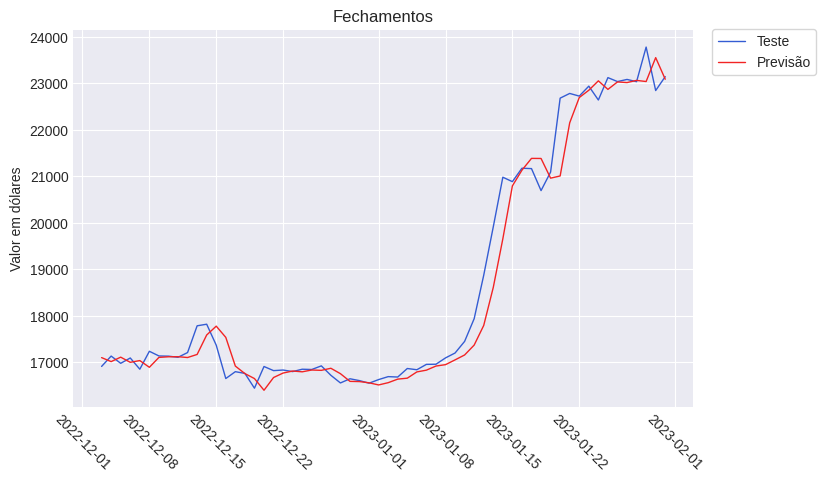

In [59]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [60]:
metricas[5] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 6: Denso (dados multivariados)

In [61]:
dados = df['Fechamento'].to_numpy().astype('float32')
premios = df['Premio'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho, premios)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [62]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_6_denso_multi'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(x=janelas_treino,
           y=horizontes_treino,
           epochs=ITERACOES,
           batch_size=TAMANHO_LOTE,
           validation_data=(janelas_teste, horizontes_teste),
           callbacks=[criar_marco_modelo(modelo_nome, caminho=CAMINHO_MARCOS)],
           verbose=0)

CPU times: user 26.7 s, sys: 930 ms, total: 27.6 s
Wall time: 41.5 s


In [63]:
modelo.summary()

Model: "modelo_6_denso_multi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu (Dense)         (None, 128)               1152      
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [64]:
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 3ms/step - loss: 919.7617 - mae: 919.7617 - mse: 1816686.6250


[919.7616577148438, 919.7616577148438, 1816686.625]

In [65]:
modelo = load_model(os.path.join(CAMINHO_MARCOS, modelo_nome))
modelo.evaluate(janelas_teste, horizontes_teste)

20/20 [==============================] - 0s 2ms/step - loss: 890.5759 - mae: 890.5759 - mse: 1740802.1250


[890.575927734375, 890.575927734375, 1740802.125]

In [66]:
previsoes = modelo.predict(janelas_teste)

20/20 [==============================] - 0s 2ms/step


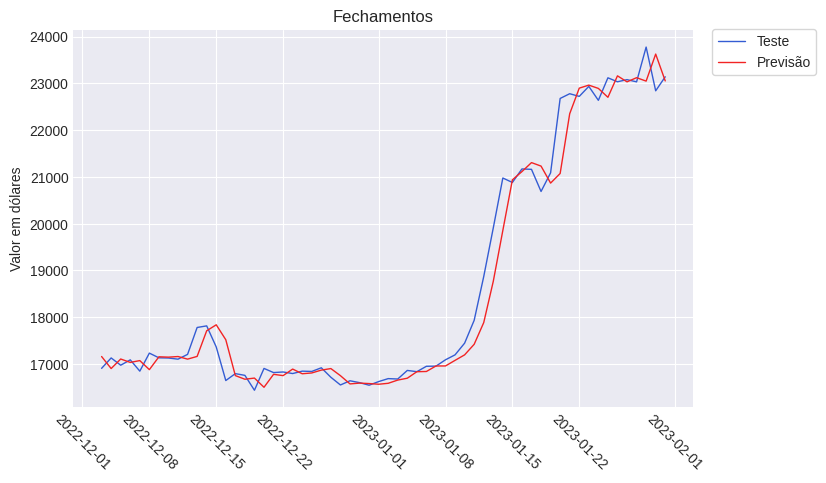

In [67]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [68]:
metricas[6] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 7: N-BEATS

N-BEATS: Neural basis expansion analysis for interpretable time series forecasting https://arxiv.org/abs/1905.10437

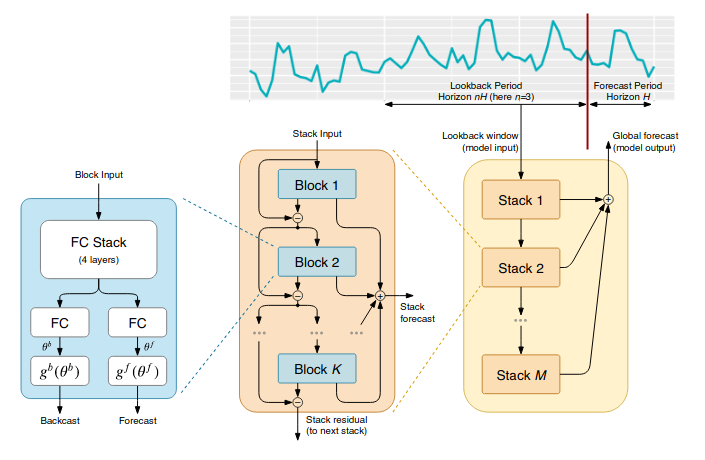

(Do artigo) **Figure 1: Proposed architecture**. The basic building block is a multi-layer Fully Connected (FC) network with ReLU nonlinearities. It predicts basis expansion coefficients both forward, $\theta^f$ (forecast), and backward, $\theta^b$ (backcast). Blocks are organized into stacks using doubly residual stacking principle. A stack may have layers with shared $g^b$ and $g^f$. Forecasts are aggregated in hierarchical fashion. This enables building a very deep neural network with interpretable outputs.


Making new Layers and Models via subclassing https://www.tensorflow.org/guide/keras/custom_layers_and_models

De acordo com o [código fonte](https://github.com/tensorflow/tensorflow/blob/fcc4b966f1265f466e82617020af93670141b009/tensorflow/python/keras/engine/base_layer.py#L308-L316) (em 09.02.2023), os kwargs permitidos pela classe `Layer` são: `input_dim`, `input_shape`, `batch_input_shape`, `batch_size`, `weights`, `activity_regularizer` e `autocast`. Além destes, `Layer` possui os argumentos `trainable`, `name`, `dtype` e `dynamic`.

### Camada de bloco. Classe NBeatsBlock.

A seção 3 do artigo descreve a arquitetura do modelo. Para este modelo foi utilizada a arquitetura genérica, descrita na seção 3.3, que não utiliza conhecimentos específicos de séries temporais.

In [69]:
class NBeatsBlock(Layer):
    def __init__(self,
                 input_size: int,
                 horizon: int,
                 n_neurons: int,
                 **kwargs):

        super().__init__(**kwargs)

        self.input_size = input_size  # Tamanho da entrada.
        self.horizon    = horizon     # Tamanho da saída.
        self.n_neurons  = n_neurons   # Quantidade de neurônios.

        self.theta_size = input_size + horizon  # Tamanho do coeficiente de expansão.

        self.hidden      = [Dense(units=n_neurons, activation='relu') for _ in range(4)]  # Camadas densas (FC) ReLU (x4).
        self.theta_layer = Dense(units=self.theta_size, activation='linear')              # Camada theta linear, para backcast e forecast.

    def call(self, inputs):

        x = inputs

        for layer in self.hidden:
            x = layer(x)

        theta = self.theta_layer(x)

        backcast = theta[:, :self.input_size]
        forecast = theta[:, -self.horizon:]

        return backcast, forecast

### Teste da classe NBeatsBlock

In [70]:
tf.random.set_seed(SEMENTE)

camada_teste = NBeatsBlock(input_size=7,
                           horizon=1,
                           n_neurons=128)

In [71]:
entradas_teste = tf.expand_dims(tf.range(janela_tamanho) + 1, axis=0)
entradas_teste

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [72]:
backcast, forecast = camada_teste(entradas_teste)

backcast.numpy(), forecast.numpy()

(array([[ 0.34613284,  0.1284557 , -0.0659485 , -0.9127117 ,  0.29758048,
         -0.0966064 ,  0.37853897]], dtype=float32),
 array([[-0.10101879]], dtype=float32))

### Fusão de janelas e horizontes em datasets para ganho de performance.

Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance

In [73]:
dados = df['Fechamento'].to_numpy().astype('float32')
janela_tamanho = 7
horizonte_tamanho = 1

janelas, horizontes = criar_janelas(dados, janela_tamanho, horizonte_tamanho)

janelas_treino, janelas_teste, horizontes_treino, horizontes_teste = separar_janelas_treino_teste(janelas, horizontes, tamanho_teste=0.2)

In [74]:
dataset_janelas_treino    = Dataset.from_tensor_slices(janelas_treino)
dataset_janelas_teste     = Dataset.from_tensor_slices(janelas_teste)
dataset_horizontes_treino = Dataset.from_tensor_slices(horizontes_treino)
dataset_horizontes_teste  = Dataset.from_tensor_slices(horizontes_teste)

dataset_treino = Dataset.zip((dataset_janelas_treino, dataset_horizontes_treino))
dataset_teste  = Dataset.zip((dataset_janelas_teste, dataset_horizontes_teste))

dataset_treino = dataset_treino.batch(1024).prefetch(AUTOTUNE)
dataset_teste  = dataset_teste.batch(1024).prefetch(AUTOTUNE)

dataset_treino, dataset_teste

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

### Hiperparâmetros (Tabela 18)

In [75]:
NBEATS_ITERACOES = 5000
NBEATS_NEURONIOS = 512
NBEATS_PILHAS    = 30
NBEATS_ENTRADA   = janela_tamanho * horizonte_tamanho
NBEATS_HORIZONTE = horizonte_tamanho

### Conexões residuais (Seção 3.2)

https://en.wikipedia.org/wiki/Residual_neural_network

https://paperswithcode.com/method/resnet

In [76]:
tensor_teste_1 = tf.range(10) + 10
tensor_teste_2 = tf.range(10)

subtracao = Subtract()([tensor_teste_1, tensor_teste_2])
adicao    = Add()([tensor_teste_1, tensor_teste_2])

print(f"Tensor 1..: {tensor_teste_1.numpy()}")
print(f"Tensor 2..: {tensor_teste_2.numpy()}")
print(f"Subtração.: {subtracao.numpy()}")
print(f"Adição....: {adicao.numpy()}")

Tensor 1..: [10 11 12 13 14 15 16 17 18 19]
Tensor 2..: [0 1 2 3 4 5 6 7 8 9]
Subtração.: [10 10 10 10 10 10 10 10 10 10]
Adição....: [10 12 14 16 18 20 22 24 26 28]


### Modelo

In [77]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_7_n_beats'

entradas = Input(shape=(NBEATS_ENTRADA), name='camada_entrada')

residuo, previsao = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                horizon=NBEATS_HORIZONTE,
                                n_neurons=NBEATS_NEURONIOS,
                                name='bloco_0')(entradas)

for p in range(1, NBEATS_PILHAS):

    residuo_pilha, previsao_pilha = NBeatsBlock(input_size=NBEATS_ENTRADA,
                                                horizon=NBEATS_HORIZONTE,
                                                n_neurons=NBEATS_NEURONIOS,
                                                name=f'bloco_{p}')(residuo)

    residuo  = Subtract(name=f"subtracao_{p}")([residuo, residuo_pilha])
    previsao = Add(name=f"adicao_{p}")([previsao, previsao_pilha])

modelo = Model(inputs=entradas, outputs=previsao, name=modelo_nome)

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

modelo.fit(dataset_treino,
           epochs=NBEATS_ITERACOES,
           validation_data=dataset_teste,
           callbacks=[EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                      ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)],
           verbose=0)


Epoch 960: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1346: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1446: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 5min 28s, sys: 9.13 s, total: 5min 37s
Wall time: 6min 27s


In [78]:
modelo.summary()

Model: "modelo_7_n_beats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada (InputLayer)    [(None, 7)]          0           []                               
                                                                                                  
 bloco_0 (NBeatsBlock)          ((None, 7),          796168      ['camada_entrada[0][0]']         
                                 (None, 1))                                                       
                                                                                                  
 bloco_1 (NBeatsBlock)          ((None, 7),          796168      ['bloco_0[0][0]']                
                                 (None, 1))                                                       
                                                                                   

In [79]:
modelo.evaluate(dataset_teste)

1/1 [==============================] - 0s 72ms/step - loss: 889.0425 - mae: 889.0425 - mse: 1702641.3750


[889.04248046875, 889.04248046875, 1702641.375]

In [80]:
previsoes = modelo.predict(dataset_teste)

1/1 [==============================] - 2s 2s/step


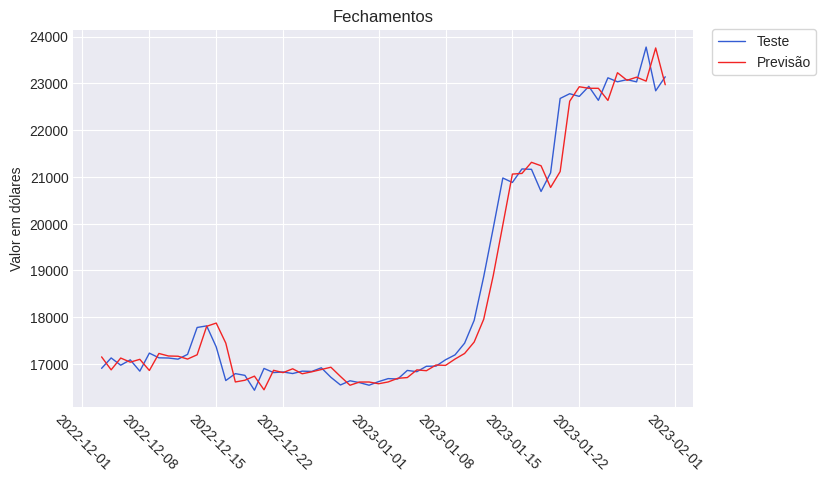

In [81]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(previsoes),
               inicio=-60)

In [82]:
metricas[7] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(previsoes))

## Modelo 8: Conjunto, ou grupo, de modelos

### Funções

In [83]:
def obter_modelos(horizonte,
                  dados_treino,
                  dados_teste,
                  modelos_por_perda=10,
                  iteracoes=1000,
                  funcoes_perda=['mae', 'mse', 'mape']):

    conjunto_modelos = []

    for m in range(modelos_por_perda):

        for perda in funcoes_perda:

            modelo_nome = f'conjunto_modelo_{m}_perda_{perda}'

            print(f"Treinando modelo {modelo_nome} com {iteracoes} iterações.")

            modelo = Sequential(name=modelo_nome)

            modelo.add(Dense(units=128, kernel_initializer='he_normal', activation='relu', name='camada_relu_0'))
            modelo.add(Dense(units=128, kernel_initializer='he_normal', activation='relu', name='camada_relu_1'))
            modelo.add(Dense(units=horizonte, activation='linear', name='camada_saida'))

            modelo.compile(loss=perda,
                           optimizer=Adam(),
                           metrics=['mae', 'mse'])
            
            modelo.fit(dados_treino,
                       epochs=iteracoes,
                       validation_data=dados_teste,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                                  ReduceLROnPlateau(monitor='val_loss', patience=50)],
                       verbose=0)
            
            conjunto_modelos.append(modelo)

    return conjunto_modelos

def obter_previsoes(modelos, dados_teste):
    
    conjunto_previsoes = []

    for modelo in modelos:

        print(f'Prevendo com modelo {modelo.name}.')

        previsoes = modelo.predict(dados_teste)

        conjunto_previsoes.append(previsoes)
    
    return tf.constant(tf.squeeze(conjunto_previsoes))

### Modelos

In [84]:
%%time

conjunto_modelos = obter_modelos(horizonte=horizonte_tamanho,
                                 dados_treino=dataset_treino,
                                 dados_teste=dataset_teste,
                                 modelos_por_perda=5)

Treinando modelo conjunto_modelo_0_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mape com 1000 iterações.
CPU times: user 5min

In [85]:
conjunto_previsoes = obter_previsoes(modelos=conjunto_modelos,
                                     dados_teste=dataset_teste)

Prevendo com modelo conjunto_modelo_0_perda_mae.
1/1 [==============================] - 0s 47ms/step
Prevendo com modelo conjunto_modelo_0_perda_mse.
1/1 [==============================] - 0s 36ms/step


Prevendo com modelo conjunto_modelo_0_perda_mape.
1/1 [==============================] - 0s 38ms/step
Prevendo com modelo conjunto_modelo_1_perda_mae.


1/1 [==============================] - 0s 39ms/step
Prevendo com modelo conjunto_modelo_1_perda_mse.
1/1 [==============================] - 0s 34ms/step
Prevendo com modelo conjunto_modelo_1_perda_mape.
1/1 [==============================] - 0s 38ms/step
Prevendo com modelo conjunto_modelo_2_perda_mae.
1/1 [==============================] - 0s 42ms/step
Prevendo com modelo conjunto_modelo_2_perda_mse.
1/1 [==============================] - 0s 36ms/step
Prevendo com modelo conjunto_modelo_2_perda_mape.
1/1 [==============================] - 0s 37ms/step
Prevendo com modelo conjunto_modelo_3_perda_mae.
1/1 [==============================] - 0s 38ms/step
Prevendo com modelo conjunto_modelo_3_perda_mse.
1/1 [==============================] - 0s 39ms/step
Prevendo com modelo conjunto_modelo_3_perda_mape.
1/1 [==============================] - 0s 44ms/step
Prevendo com modelo conjunto_modelo_4_perda_mae.
1/1 [==============================] - 0s 38ms/step
Prevendo com modelo conjunto_modelo_

How to Combine Predictions for Ensemble Learning: https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [86]:
conjunto_previsoes_media     = tf.reduce_mean(conjunto_previsoes, axis=0)
conjunto_previsoes_desvio    = tf.math.reduce_std(conjunto_previsoes, axis=0)
conjunto_previsoes_intervalo = conjunto_previsoes_desvio * 1.96  # https://en.wikipedia.org/wiki/1.96
conjunto_previsoes_superior  = conjunto_previsoes_media + conjunto_previsoes_intervalo
conjunto_previsoes_inferior  = conjunto_previsoes_media - conjunto_previsoes_intervalo

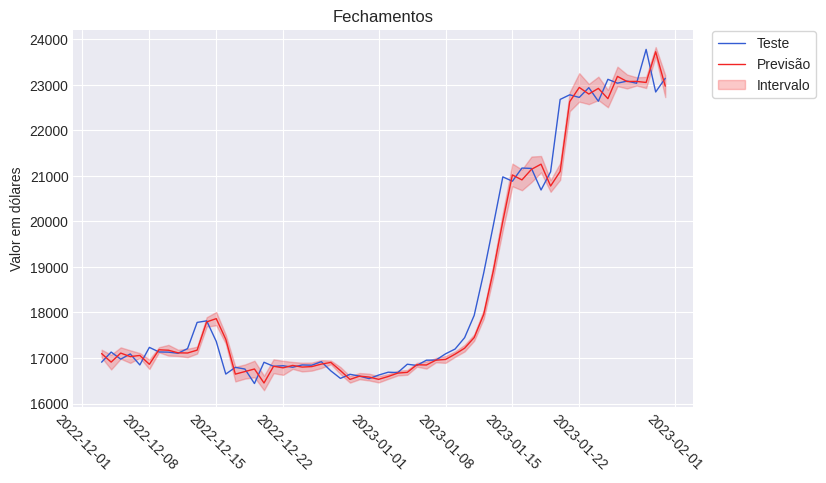

In [87]:
grafico_series(X_teste=X_test[-len(janelas_teste):], y_teste=tf.squeeze(horizontes_teste),
               X_previsao=X_test[-len(janelas_teste):], y_previsao=tf.squeeze(conjunto_previsoes_media),
               superior=conjunto_previsoes_superior, inferior=conjunto_previsoes_inferior,
               inicio=-60)

In [88]:
metricas[8] = metricas_modelo(tf.squeeze(horizontes_teste), tf.squeeze(conjunto_previsoes_media))

## Modelo 9: Prevendo o futuro

### Dados completos

In [89]:
dataset_janelas    = Dataset.from_tensor_slices(janelas)
dataset_horizontes = Dataset.from_tensor_slices(horizontes)

dataset_completo = Dataset.zip((dataset_janelas, dataset_horizontes))

dataset_completo = dataset_completo.batch(1024).prefetch(AUTOTUNE)

dataset_completo

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

### Modelo

In [90]:
%%time

tf.random.set_seed(SEMENTE)

modelo_nome = 'modelo_9_futuro'

modelo = Sequential(name=modelo_nome)

modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu_0'))
modelo.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN, name='camada_relu_1'))
modelo.add(Dense(units=horizonte_tamanho, activation=ATIVACAO_HORIZONTE, name='camada_saida'))

modelo.compile(loss=PERDA,
               optimizer=Adam())

modelo.fit(dataset_completo,
           epochs=ITERACOES,
           verbose=0)

CPU times: user 3.51 s, sys: 117 ms, total: 3.62 s
Wall time: 3.88 s


In [91]:
modelo.summary()

Model: "modelo_9_futuro"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_relu_0 (Dense)       (None, 128)               1024      
                                                                 
 camada_relu_1 (Dense)       (None, 128)               16512     
                                                                 
 camada_saida (Dense)        (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


### Função de previsões

In [92]:
def gerar_previsoes_futuro(modelo, dados, quantidade_dias, janela_tamanho):

    previsoes = []
    janela    = tf.squeeze(dados[-janela_tamanho:])

    for _ in range(quantidade_dias):

        previsao = modelo.predict(tf.expand_dims(janela, axis=0), verbose=0)

        previsoes.append(tf.squeeze(previsao).numpy())

        janela = np.append(janela, previsao)[-janela_tamanho:]

        print(f"{janela} -> {previsao}")

    return previsoes

### Previsão

In [93]:
quantidade_dias = 7

previsoes = gerar_previsoes_futuro(modelo, horizontes, quantidade_dias, janela_tamanho)

[23032.777 23078.729 23031.09  23774.566 22840.139 23139.283 23004.412] -> [[23004.412]]
[23078.729 23031.09  23774.566 22840.139 23139.283 23004.412 23034.666] -> [[23034.666]]
[23031.09  23774.566 22840.139 23139.283 23004.412 23034.666 23056.045] -> [[23056.045]]
[23774.566 22840.139 23139.283 23004.412 23034.666 23056.045 22918.592] -> [[22918.592]]
[22840.139 23139.283 23004.412 23034.666 23056.045 22918.592 22918.004] -> [[22918.004]]
[23139.283 23004.412 23034.666 23056.045 22918.592 22918.004 22869.596] -> [[22869.596]]
[23004.412 23034.666 23056.045 22918.592 22918.004 22869.596 22845.213] -> [[22845.213]]


In [94]:
df_fevereiro = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/BTC_USD_20230201_20230207.csv',
                           header=0,
                           names=COLUNAS,
                           usecols=COLUNAS,
                           parse_dates=['Data'],
                           index_col=['Data'])

df_fevereiro['Previsão'] = previsoes
df_fevereiro['Diferença'] = df_fevereiro['Previsão'] - df_fevereiro['Fechamento']

In [95]:
df_fevereiro[['Fechamento', 'Previsão', 'Diferença']]

,Fechamento,Previsão,Diferença
Data,,,
2023-02-01,23723.769531,23004.412109,-719.357422
2023-02-02,23471.871094,23034.666016,-437.205078
2023-02-03,23449.322266,23056.044922,-393.277344
2023-02-04,23331.847656,22918.591797,-413.255859
2023-02-05,22955.666016,22918.003906,-37.662110
2023-02-06,22760.109375,22869.595703,109.486328
2023-02-07,23264.291016,22845.212891,-419.078125


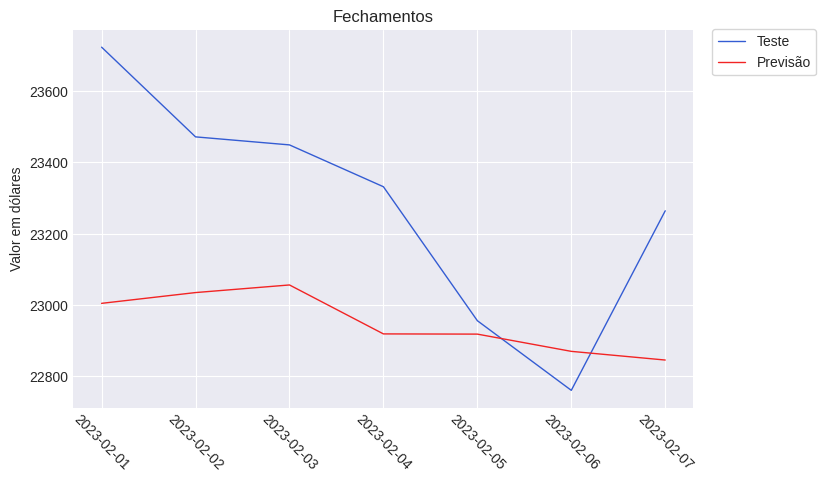

In [96]:
grafico_series(X_teste=df_fevereiro.index, y_teste=df_fevereiro['Fechamento'],
               X_previsao=df_fevereiro.index, y_previsao=df_fevereiro['Previsão'])

# Outros modelos

Other kinds of time series forecasting models which can be used for baselines and actual forecasts: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

# Comparação dos modelos

In [97]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5,6,7,8
Mean Absolute Error,860.374223,896.024658,966.466980,1027.238281,911.986267,932.226379,890.575928,889.042480,872.317322
Root Mean Squared Error,1274.550527,1315.464844,1385.076294,1464.540894,1336.888428,1346.860596,1319.394653,1304.852905,1291.549194
Mean Absolute Percentage Error,0.024247,0.025313,0.027507,0.029380,0.025885,0.026357,0.025178,0.025018,0.024590
Mean Absolute Scaled Error,1.001516,1.043015,1.130523,1.188883,1.061595,1.085155,1.036672,1.034887,1.015418


In [98]:
df_metricas['Mean Absolute Error'].sort_values()

0     860.374223
8     872.317322
7     889.042480
6     890.575928
1     896.024658
4     911.986267
5     932.226379
2     966.466980
3    1027.238281
Name: Mean Absolute Error, dtype: float64